# Projection on vertical modes

This notebook contains instruction for computing mean strat and corresponding vertical modes, and then project fields onto this basis. It is written to deal with cos/sin harmonics fields but the method is general.

N.B.: in this case, linear EOS with Tcoef=1, hence $\rho=T$

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import crocosi.postp as pp
import crocosi.gridop as gop
import crocosi.vmodes as vmd
import sys
sys.path.append('./dev')
#import cswbib as bib # a few useful functions that should probably be in gridop or Vmodes

from xgcm import Grid
import pickle

/home1/datahome/nlahaye/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
### this is not mandatory: dask cluster

from dask.distributed import Client, LocalCluster
cluster = LocalCluster() # dashboard_address=':8787'
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39525 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [2]:
docal = False # load sub-dataset used in this example and compute mean state or load it from zar
dosave = True if docal else False # change only first bool

filename = "./proj_mode_data.p"

root_path = '/home/datawork-lops-osi/equinox/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
    

# Compute or load data and mean stratification
loading simulation from netcdf files using postp Run class

$x$-average of SSH, compute mean grid, then mean $N^2$ on this grid

In [3]:
if docal:

    it = 1 # time index (working with one time index for this example)
    sliy = slice(100, -100, 2)

    r = pp.Run(root_path+run, prefix='file_',open_nc=['grid','his'], verbose=True)
    ds = r['his'].isel(time=it, y_rho=sliy)

    ### N.B.: Here we should specify wether some dimensions are periodic (e.g. x)### mean ssh and z-grids

    ssh_mean = ds.ssh_a.mean(dim='x_rho')
    h_mean = r['grid'].h.mean(dim="x_rho")
    
    fig, axs = plt.subplots(1, 2, sharey=True)
    ssh_std = ds.ssh_a.std(dim="x_rho")
    ds.ssh_a.plot(ax=axs[0])
    ssh_mean.plot(ax=axs[1], y="y_rho", color="k")
    axs[1].fill_betweenx(ds.y_rho, 
                         ssh_mean-ssh_std, 
                         ssh_mean+ssh_std, 
                         color="grey", alpha=.7)

    axs[1].grid(True)
    axs[1].yaxis.set_label_position("right")
    axs[0].set_aspect('equal')

    nx = ds.x_rho.size

    zr_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='r', hgrid='r').persist()
    zw_mean = gop.get_z(r, zeta=ssh_mean, h=h_mean, vgrid='w', hgrid='r').persist()
    
### mean T and N2
    z_rho = r.get_z(zeta=ds.ssh_a, vgrid="r", hgrid="r")
    T_mean = gop.interp2z(zr_mean, z_rho, ds.T_a).mean("x_rho") # interpolate on mean grid
    N2 = r.get_N2(T_mean, zr_mean).chunk({"s_w":-1}) # compute stratif
    N2 = N2.assign_coords(z_w=zw_mean).persist()

    ### some bricolage in case N2<0
    Nmin = 1e-8
    prov = N2.values<Nmin
    if (N2<=0).any():
        print("wow, I had to fix {0}/{1} negative values in N^2".format(prov.sum(),prov.size))
        N2 = N2.where(N2>Nmin, Nmin)

    ### plot result    
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,3))
    ax = axs[0]
    hpc = np.sqrt(N2).plot(ax=ax, y="s_w")
    ax.set_title("N2 (for modes)")
    ax = axs[1]
    gop.interp2z(zr_mean, z_rho, ds.T_a).mean("x_rho").plot(ax=ax, y="s_rho")
    ax.set_title("B_a, x-avg")
    ax = axs[2]
    gop.interp2z(zr_mean.drop(["time_instant", "time_counter"]), z_rho, r.xgrid.interp(ds.u_a, "xi", boundary="fill")\
            .chunk({"x_rho":-1})).mean("x_rho").plot(ax=ax, y="s_rho")
    ax.set_title("U_a, x-avg")
    
### prep. and save data to zarr
    ds_mean = xr.Dataset({"N2":N2, "Tmoy":T_mean.assign_coords(z_rho=zr_mean)}, compat="override")
    ds_r = ds.isel(x_rho=nx//2)
    u_rho = r.xgrid.interp(ds.u_t_cos, "xi", boundary="extend").isel(x_rho=nx//2).rename('u_t_cos')
    ds_r = xr.merge([ds_r.T_t_cos, ds_r.w_t_cos, ds_r.ssh_a])
    ds_r['u_t_cos'] = u_rho # PUZZLING: merging directly u_rho with the others creates lots of NaN!

    # adapt and attach grid
    gridcoord = {key:val.coords for key,val in r.xgrid.axes.items() if key not in "xi"}
    xgrid = Grid(ds_r, coords=gridcoord, periodic=['eta'])
    
    # save:
    if dosave:
        rg = pp.Run(root_path+run, prefix='file_',open_nc=['grid'], verbose=False)
        stored_data = {'r': rg, 'ds_mean': ds_mean, 'ds_r': ds_r, 'xgrid': xgrid}
        pickle.dump(stored_data, open(filename, "wb"))
    
    ds = ds_r

In [4]:
### load stored data

if not docal:
    stored_data = pickle.load(open(filename, "rb"))
    ds, ds_mean = stored_data['ds_r'], stored_data['ds_mean']
    N2, zr_mean, zw_mean = ds_mean.N2, ds_mean.z_rho, ds_mean.z_w
    r, xgrid = stored_data['r'], stored_data['xgrid']
    
if False:
    ds_mean = xr.load_dataset(filemean+".nc")
    ds = xr.load_dataset(filename+".nc")
    N2, zr_mean, zw_mean = ds_mean.N2, ds_mean.z_rho, ds_mean.z_w
    if "xgrid" not in ds.attrs:
        with open(filegrid, mode="r") as fp:
            gridcoord = json.load(fp)
        ds.attrs['xgrid'] = Grid(ds, coords=gridcoord)
    xgrid = ds.attrs['xgrid']

    # I still need to load the run to initialize the Run object    
    r = pp.Run(root_path+run, prefix='file_',open_nc=['grid'], verbose=True)
    

## Compute vertical modes N2(x,y,$\bar{z}$) -> $\phi_{n}$(x,y,$\bar{z}$)

Use Vmodes class (using dask arrays)

<xarray.Dataset>
Dimensions:       (mode: 11, s_rho: 50, s_w: 51, y_rho: 261)
Coordinates:
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
  * s_w           (s_w) float64 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
  * y_rho         (y_rho) float64 3.98e+05 4.06e+05 ... 2.47e+06 2.478e+06
    y_u           (y_rho) float32 dask.array<chunksize=(261,), meta=np.ndarray>
    time_instant  float64 dask.array<chunksize=(), meta=np.ndarray>
    time_counter  float64 1.54e+03
    z_w           (s_w, y_rho) float32 dask.array<chunksize=(51, 261), meta=np.ndarray>
    z_rho         (s_rho, y_rho) float32 dask.array<chunksize=(50, 261), meta=np.ndarray>
  * mode          (mode) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    N2            (y_rho, s_w) float64 dask.array<chunksize=(261, 51), meta=np.ndarray>
    c             (mode, y_rho) float64 dask.array<chunksize=(11, 261), meta=np.ndarray>
    phi           (mode, s_rho, y_rho) float64 dask.array<chunksi

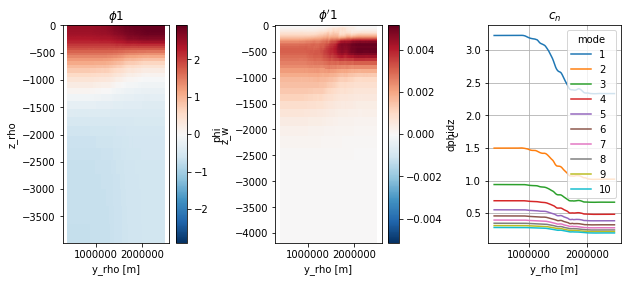

In [5]:
### compute modes
nmodes = 10
#vmodes = vmd.Vmodes(r.xgrid, nmodes, zmoy, zwoy, N2, persist=True)
vmodes = vmd.Vmodes(xgrid, zr_mean, zw_mean, N2, nmodes, persist=True) # working version

# plot result (for one mode)
imod = 1
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(10,4))
ax=axs[0]
vmodes.ds.phi.sel(mode=imod).plot(x="y_rho", y="z_rho", ax=ax)
ax.set_title(r"$\phi $"+str(imod))
ax=axs[1]
vmodes.ds.dphidz.sel(mode=imod).plot(x="y_rho", y="z_w", ax=ax)
ax.set_title(r"$\phi' $"+str(imod))
ax = axs[2]
vmodes.ds.c.isel(mode=slice(1,None)).plot.line(x="y_rho", ax=ax)
ax.grid(True)
ax.set_title(r"$c_n$")
fig.subplots_adjust(wspace=.6)

# show result
vmodes.ds

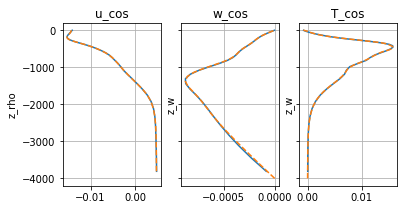

In [6]:
### Application: project fields on base of modes, then reconstruct and compare with original field

jy, ix = 100, 0

sds = ds.isel(y_rho=[jy])
h0 = r.ds['grid'].h.isel(x_rho=ix).sel(y_rho=sds.y_rho)

z_rho = r.get_z(zeta=sds.ssh_a, h=h0, hgrid="r", vgrid="r")
z_w = r.get_z(zeta=sds.ssh_a, h=h0, hgrid="r", vgrid="w")

uu = sds.u_t_cos.assign_coords(z_rho=z_rho)
un = vmodes.project(uu, "p", align=True, z=True)\
            .rename("un")\
            .persist() 

ww = sds.w_t_cos.assign_coords(z_rho=z_rho)
wn = vmodes.project_w(ww, align=True, z=True).persist()

bb = sds.T_t_cos.assign_coords(z_rho=z_rho)
bn = vmodes.project_b(bb, align=True, z=z_rho).persist()

### plot result
fig, axs = plt.subplots(1, 3, figsize=(6,3), sharey=True)

ax=axs[0]
uu.plot(y="z_rho", ax=ax, label="true")
#(un*vmodes.ds.phi.isel(y_rho=jy)).sum("mode").plot(y="zc", ax=ax, label="reco", linestyle="--")
vmodes.reconstruct(un).plot(y="z_rho", ax=ax, label="reco", linestyle="--")
ax.set_title('u_cos')

ax = axs[1]
ww.plot(y="z_rho", ax=ax, label="true")
vmodes.reconstruct_w(wn).plot(y="z_w", ax=ax, label="reco", linestyle="--")
ax.set_title('w_cos')

ax = axs[2]
bb.plot(y="z_rho", ax=ax, label="true")
vmodes.reconstruct_b(bn).plot(y="z_w", ax=ax, label="reco", linestyle="--")
ax.set_title('T_cos')

for ax in axs:
    ax.grid(True)

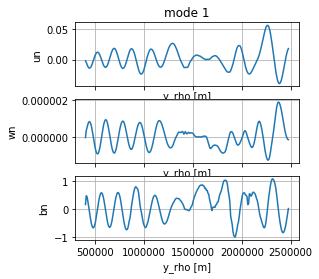

In [9]:
### different case: project over one mode and plot result

h0, _ = xr.align(r.ds['grid'].h.isel(x_rho=ix), ds)

z_rho = r.get_z(zeta=ds.ssh_a, h=h0, hgrid="r", vgrid="r")
z_w = r.get_z(zeta=ds.ssh_a, h=h0, hgrid="r", vgrid="w")

uu = ds.u_t_cos.assign_coords(z_rho=z_rho)
un = vmodes.project(uu, "p", z=True, sel={'mode':imod})\
            .rename("un")\
            .persist() 

ww = ds.w_t_cos.assign_coords(z_rho=z_rho)
wn = vmodes.project_w(ww, z=True, sel={'mode':imod}).persist()

bb = ds.T_t_cos.assign_coords(z_rho=z_rho)
bn = vmodes.project_b(bb, z=z_rho, sel={"mode":imod}).persist()

### plot result
fig, axs = plt.subplots(3, 1, figsize=(4,4), sharex=True)

ax=axs[0]
un.plot(x="y_rho", ax=ax)
ax.set_title('mode {}'.format(str(imod)))
ax.set_ylabel('un')

ax = axs[1]
wn.plot(x="y_rho", ax=ax)
ax.set_ylabel('wn')
ax.set_title('')

ax = axs[2]
bn.plot(x="y_rho", ax=ax)
ax.set_ylabel('bn')
ax.set_title('')

for ax in axs:
    ax.grid(True)